# XGBoost

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('application_train_inner_merged.csv')

In [3]:
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

y.value_counts(normalize = True)

TARGET
0    0.901567
1    0.098433
Name: proportion, dtype: float64

In [4]:
from imblearn.over_sampling import SMOTE

resampling = SMOTE(sampling_strategy = 'minority', random_state = 42) 
X, y  = resampling.fit_resample(X, y)

y.value_counts()

TARGET
0    9956
1    9956
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

def eval_classification(model) :
    y_pred             = model.predict(X_test)
    y_pred_train       = model.predict(X_train)
    y_pred_proba       = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (Train Set)    : %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set)     : %.2f' % accuracy_score(y_test, y_pred))
    
    print('Precision (Train Set)   : %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test Set)    : %.2f' % precision_score(y_test, y_pred))
    
    print('Recall (Train Set)      : %.2f' % recall_score(y_train, y_pred_train))
    print('Recall (Test Set)       : %.2f' % recall_score(y_test, y_pred))
    
    print('F1-Score (Train Set)    : %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test Set)     : %.2f' % f1_score(y_test, y_pred))

    print('ROC-AUC (Train-Proba)   : %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC (Test-Proba)    : %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

def score_cross_validate(model) :
    score = cross_validate(model, X, y, cv = 5, scoring = 'recall', return_train_score = True)
    print('Recall (Crossval Train) : %.2f' % score['train_score'].mean())
    print('Recall (Crossval Test)  : %.2f' % score['test_score'].mean())

def show_feature_importance(model) :
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    ax = feat_importances.nlargest(25).plot(kind = 'barh', figsize = (10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score - Data Test')
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(model) :
    cm   = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = plt.cm.Blues)
    
    plt.title('Confusion Matrix - Data Test')
    plt.tight_layout()
    plt.show()

def show_best_hyperparameter(model) :
    print(model.best_estimator_.get_params())

In [7]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state = 42)
xg.fit(X_train, y_train)
eval_classification(xg)
score_cross_validate(xg)

Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.98
Recall (Train Set)      : 1.00
Recall (Test Set)       : 0.91
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.94
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
Recall (Crossval Train) : 1.00
Recall (Crossval Test)  : 0.89


In [8]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# hyperparameters = { 'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#                     'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
#                     'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'tree_method' : ['auto', 'exact', 'approx', 'hist'],

#                     'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

#                     'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]}

# xg = XGBClassifier(random_state = 42)
# xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv = 5, random_state = 42, scoring = 'roc_auc')
# xg_tuned.fit(X_train, y_train)

# eval_classification(xg_tuned)
# score_cross_validate(xg_tuned)

In [9]:
# show_best_hyperparameter(xg_tuned)

In [10]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = XGBClassifier(random_state = 42, reg_lambda = c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter XGB')
    plt.legend()
    plt.show()

In [11]:
param_values = [float(x) for x in np.linspace(0, 1, num = 11)]
# draw_learning_curve(param_values)

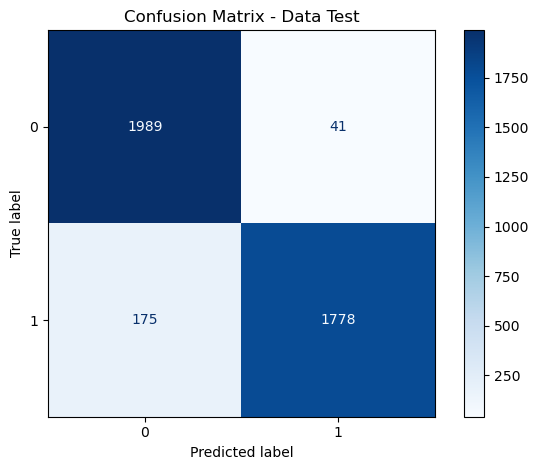

In [12]:
show_confusion_matrix(xg)

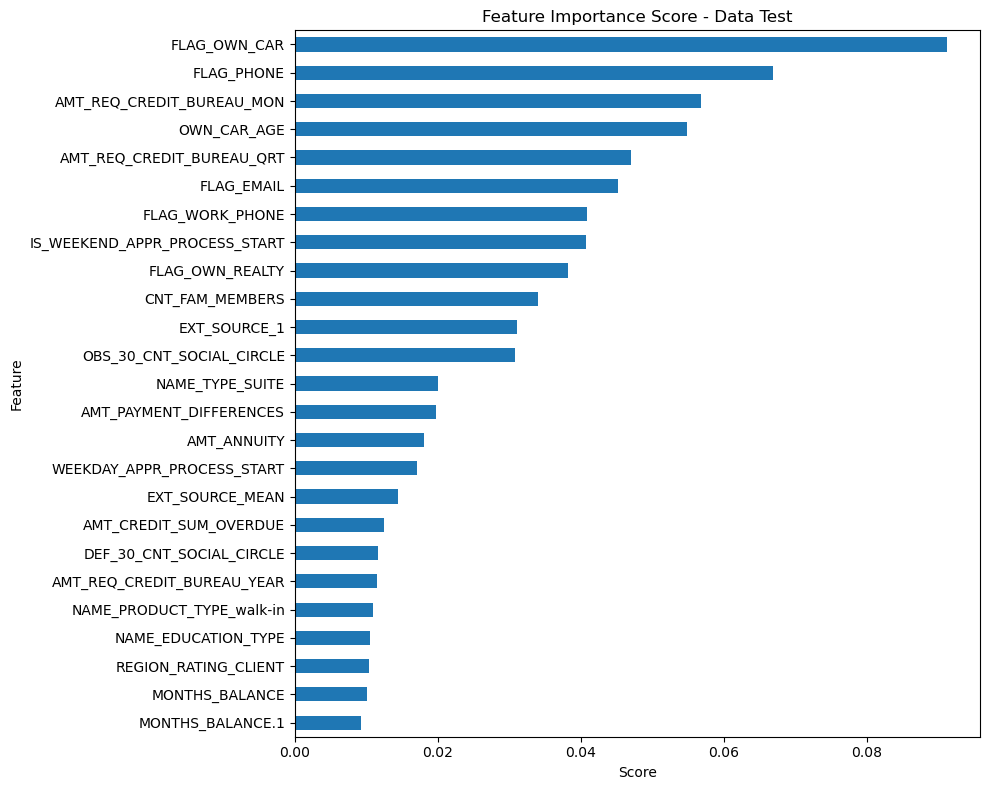

In [13]:
show_feature_importance(xg)
# xg.plot_importance(xg_tuned, max_num_features=10, importance_type='split', title='Feature Importance')
# plt.show()

In [14]:
df_train = pd.DataFrame(X_train)
df_train['dataset'] = 'train'

df_test = pd.DataFrame(X_test)
df_test['dataset'] = 'test'

In [15]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

In [16]:
predictions = xg.predict(X)
df_combined['predictions'] = predictions
df_combined['actual'] = y

In [17]:
df_combined[df_combined.predictions != df_combined.actual]

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
123                     0            0             0                0   
218                     0            0             0                1   
293                     0            0             0                1   
327                     0            0             0                1   
346                     0            1             1                1   
...                   ...          ...           ...              ...   
10845                   0            0             1                1   
10935                   0            1             1                0   
10943                   0            0             0                1   
10994                   0            0             0                1   
11040                   0            0             0                1   

       AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
123           11.119883                1                 6   
218           12.218495                6                 1   
293           11.407565                6                 6   
327           11.267249                6                 4   
346           12.049419                6                 1   
...                 ...              ...               ...   
10845         11.630709                6                 6   
10935         12.323856                6                 6   
10943         12.177211                5                 4   
10994         11.630709                6                 6   
11040         11.967181                6                 6   

       NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  \
123                      4                   1                  1  ...   
218                      1                   0                  1  ...   
293                      4                   1                  1  ...   
327                      4                   1                  1  ...   
346                      4                   3                  1  ...   
...                    ...                 ...                ...  ...   
10845                    1                   1                  1  ...   
10935                    4                   1                  1  ...   
10943                    4                   0                  1  ...   
10994                    4                   1                  1  ...   
11040                    4                   1                  5  ...   

       CNT_INSTALMENT_LOG  CNT_INSTALMENT_LOG.1  DAYS_INSTALMENT  \
123              0.670588             18.776476         0.885287   
218             -0.641143            -11.540573         1.067221   
293              0.425405             32.330806        -0.548286   
327             -0.965093            -49.170967        -0.409700   
346             -1.215131            -27.948014         0.585921   
...                   ...                   ...              ...   
10845           -0.724638            -13.768115         1.180739   
10935           -1.372156            -26.070962        -0.694165   
10943           -1.173148            -34.632563        -0.448542   
10994           -0.721961            -17.327069         0.074976   
11040           -1.144220            -26.317061         0.768672   

       DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  DAYS_ENTRY_PAYMENT_RATIO  \
123              0.884819        9.965490                  0.055995   
218              1.074378        7.630573                  0.020292   
293             -0.545782        8.812457                  0.020171   
327             -0.408305        7.566626                  0.006002   
346              0.594837        8.875178                  0.014906   
...                   ...             ...                       ...   
10845            1.163579        7.935822                  0.346648   
10935           -0.702889        9.152688                  0.039313   
10943           -0.473584        8.36628

# LightGBM

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('application_train_inner_merged.csv')

In [6]:
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

y.value_counts(normalize = True)

TARGET
0    0.901567
1    0.098433
Name: proportion, dtype: float64

In [8]:
from imblearn.over_sampling import SMOTE

resampling = SMOTE(sampling_strategy = 'minority', random_state = 42) 
X, y  = resampling.fit_resample(X, y)

y.value_counts()

TARGET
0    9956
1    9956
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

def eval_classification(model) :
    y_pred             = model.predict(X_test)
    y_pred_train       = model.predict(X_train)
    y_pred_proba       = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (Train Set)    : %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set)     : %.2f' % accuracy_score(y_test, y_pred))
    
    print('Precision (Train Set)   : %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test Set)    : %.2f' % precision_score(y_test, y_pred))
    
    print('Recall (Train Set)      : %.2f' % recall_score(y_train, y_pred_train))
    print('Recall (Test Set)       : %.2f' % recall_score(y_test, y_pred))
    
    print('F1-Score (Train Set)    : %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test Set)     : %.2f' % f1_score(y_test, y_pred))

    print('ROC-AUC (Train-Proba)   : %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC (Test-Proba)    : %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

def score_cross_validate(model) :
    score = cross_validate(model, X, y, cv = 5, scoring = 'recall', return_train_score = True)
    print('Recall (Crossval Train) : %.2f' % score['train_score'].mean())
    print('Recall (Crossval Test)  : %.2f' % score['test_score'].mean())

def show_feature_importance(model) :
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    ax = feat_importances.nlargest(25).plot(kind = 'barh', figsize = (10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score - Data Test')
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(model) :
    cm   = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = plt.cm.Blues)
    
    plt.title('Confusion Matrix - Data Test')
    plt.tight_layout()
    plt.show()

def show_best_hyperparameter(model) :
    print(model.best_estimator_.get_params())

def calculate_default_rate(model, X, y, dataset_name="dataset"):
    """
    Calculates the default rate from the predictions of a given model on a specified dataset.
    
    Parameters:
    - model: Trained model to make predictions.
    - X: Features for the dataset.
    - y: Actual target values for the dataset (1 = default, 0 = no default).
    - dataset_name: Name of the dataset being evaluated (e.g., "train" or "test").
    
    Returns:
    - default_rate: Proportion of predicted defaults.
    """
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred_default = (y_pred_proba > 0.5).astype(int)

    default_count = sum(y_pred_default)
    total_count = len(y_pred_default)
    default_rate = default_count / total_count if total_count > 0 else 0
    
    print(f"Default rate for {dataset_name} set:")
    print(f"Predicted default count: {default_count}")
    print(f"Total count: {total_count}")
    print(f"Predicted default rate: {default_rate:.2%}")

In [14]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state = 42)
lgb.fit(X_train, y_train)
eval_classification(lgb)
score_cross_validate(lgb)
calculate_default_rate(lgb, X_train, y_train, dataset_name="train")
calculate_default_rate(lgb, X_test, y_test, dataset_name="test")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13890
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
Accuracy (Train Set)    : 0.96
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.99
Recall (Train Set)      : 0.93
Recall (Test Set)       : 0.91
F1-Score (Train Set)    : 0.96
F1-Score (Test Set)     : 0.95
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
[LightGBM] [Warning] Found whitespace in feature_names,

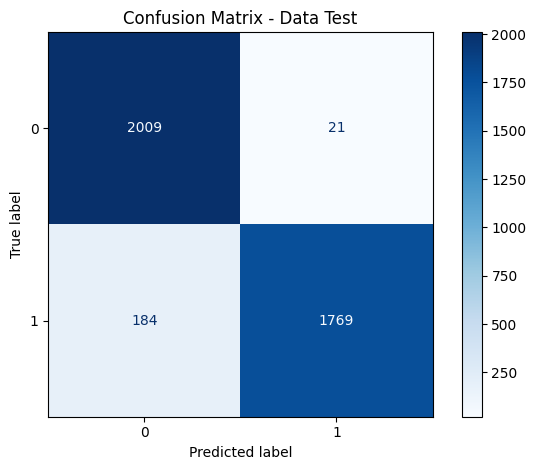

In [16]:
show_confusion_matrix(lgb)

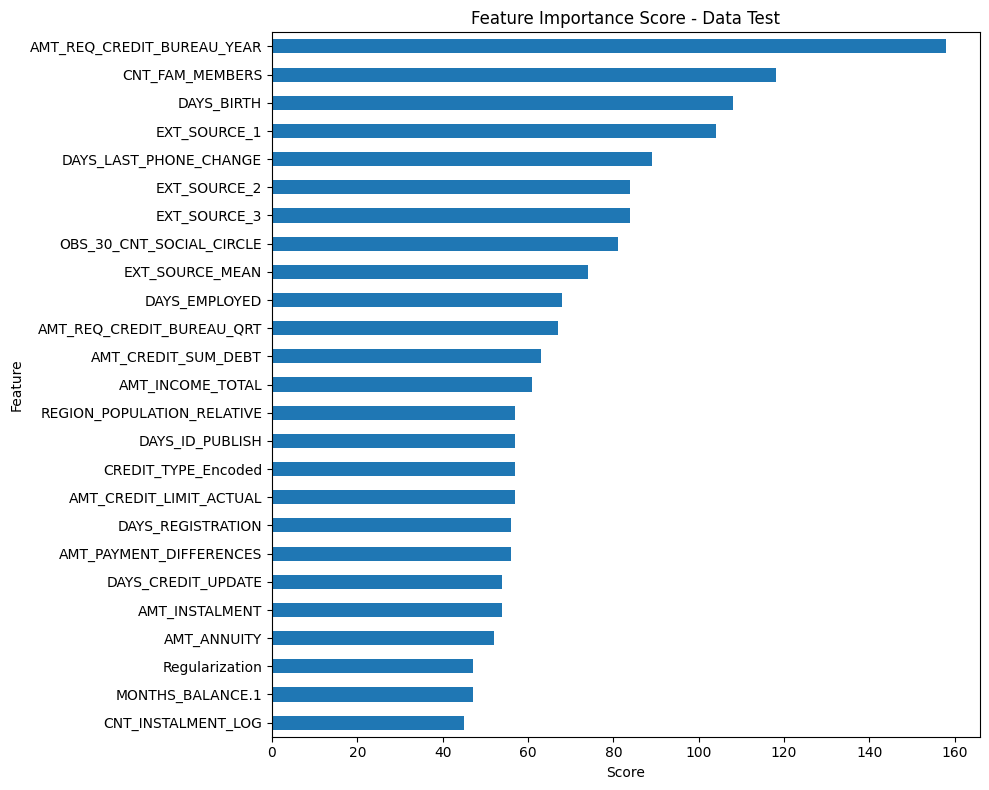

In [18]:
show_feature_importance(lgb)

In [20]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# Define the parameter distribution for LightGBM
param_dist = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': np.arange(20, 100, step=10),
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': np.arange(50, 300, step=50),
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Initialize the LightGBM classifier
lgb = LGBMClassifier(random_state=42)

# Set up Stratified K-Fold with fewer folds
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=cv_strategy,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_lgb = random_search.best_estimator_

# Evaluate the tuned model
eval_classification(best_lgb)
score_cross_validate(best_lgb)
calculate_default_rate(best_lgb, X_train, y_train, dataset_name="train")
calculate_default_rate(best_lgb, X_test, y_test, dataset_name="test")

# Print the best parameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13882
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.99
Recall (Train Set)      : 1.00
Recall (Test Set)       : 0.91
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.95
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
[LightGBM] [Warning] Found whitespace in feature_names, r

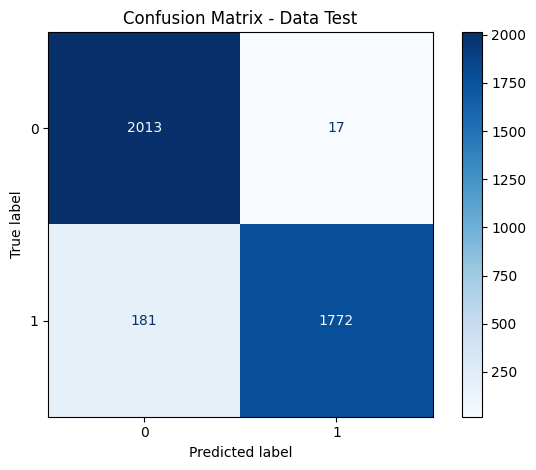

In [22]:
show_confusion_matrix(best_lgb)

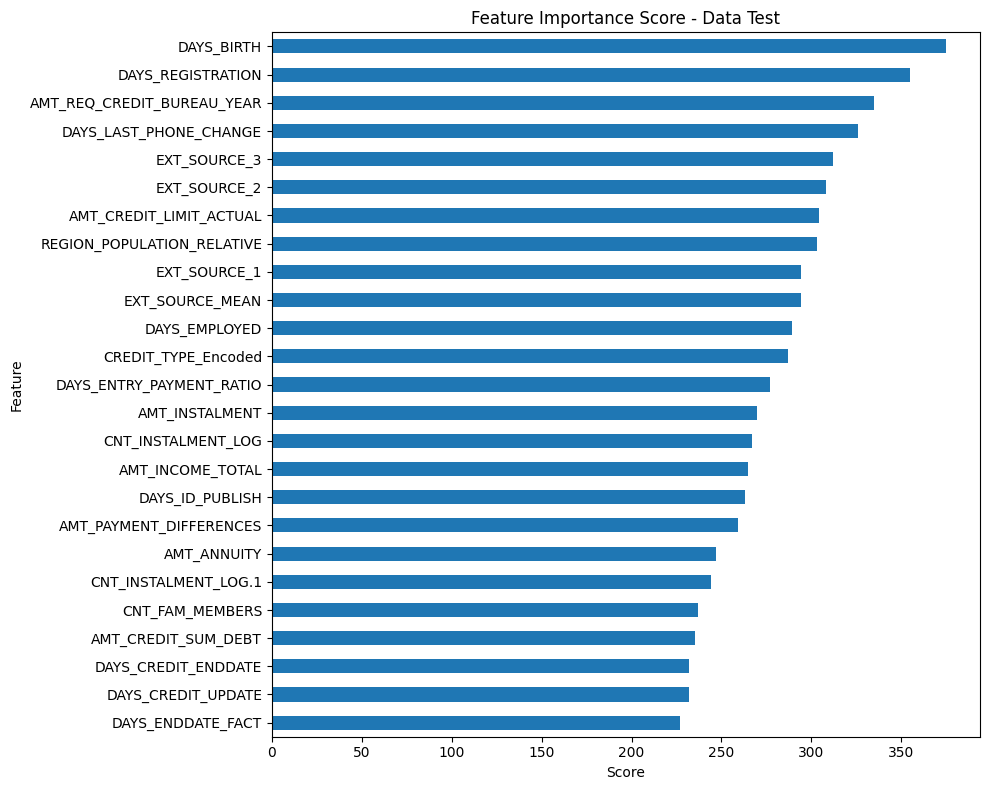

In [24]:
show_feature_importance(best_lgb)

In [26]:
from sklearn.model_selection import GridSearchCV

# Define a smaller grid for GridSearchCV to keep the computation manageable
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 50, 80],  # Fewer options to reduce search space
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],  # Reduced options
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Initialize the LightGBM classifier
lgb = LGBMClassifier(random_state=42)

# Set up Stratified K-Fold for balanced class splits
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid,
    cv=cv_strategy,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best model
grid_lgb = grid_search.best_estimator_

# Evaluate the tuned model
eval_classification(grid_lgb)
score_cross_validate(grid_lgb)
train_default_rate = calculate_default_rate(grid_lgb, X_train, y_train, dataset_name="train")
test_default_rate = calculate_default_rate(grid_lgb, X_test, y_test, dataset_name="test")

# Print the best parameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13882
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.99
Recall (Train Set)      : 1.00
Recall (Test Set)       : 0.91
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.95
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
[LightGBM] [Warning] Found whitespace in feature_names,

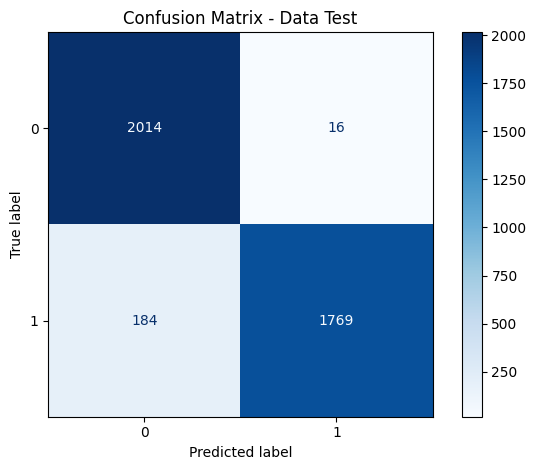

In [28]:
show_confusion_matrix(grid_lgb)

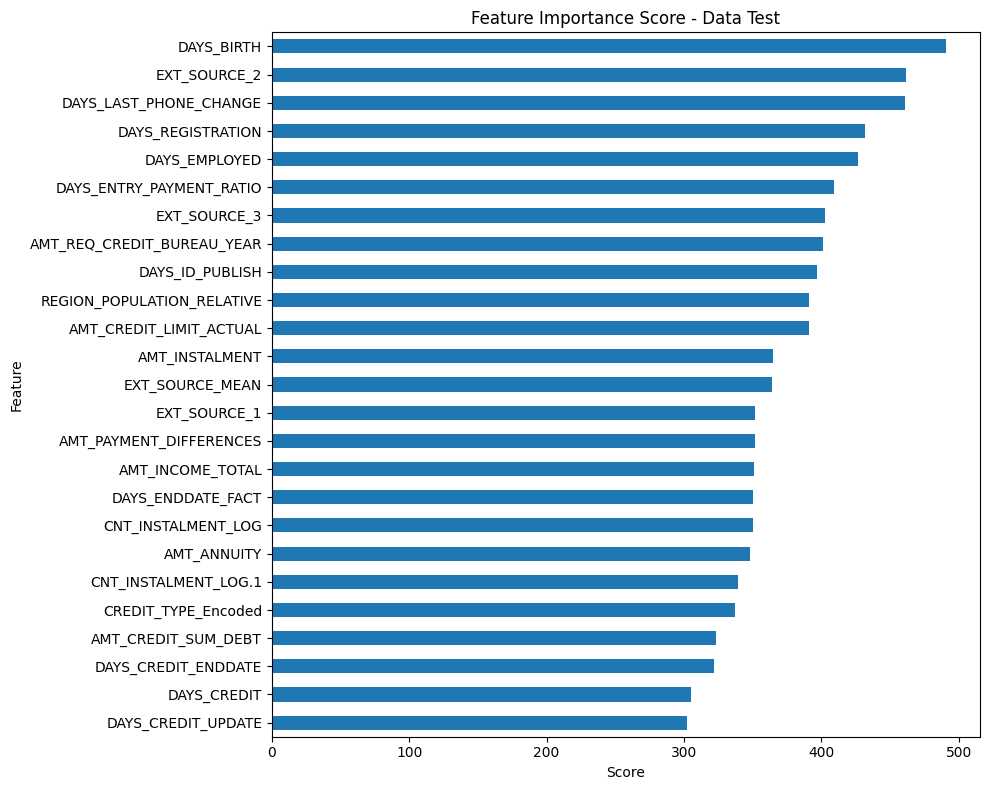

In [30]:
show_feature_importance(grid_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13882
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
learning_rate value: 0.01; train AUC: 0.9874076996548953; test AUC: 0.9752839511778015
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13

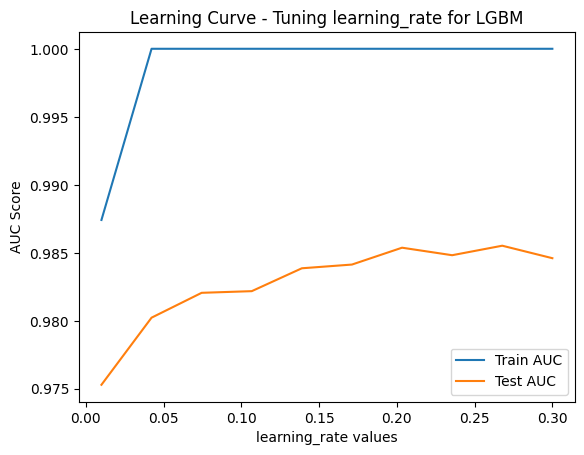

In [38]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def draw_learning_curve(param_values, base_model, param_name='learning_rate'):
    train_scores = []
    test_scores = []

    # Get the best parameters from the grid_lgb model
    base_params = base_model.get_params()

    for value in param_values:
        # Create a new model with the best parameters and update only the selected parameter
        model_params = {**base_params, param_name: value}
        model = LGBMClassifier(**model_params)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate on the training set
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:, 1])
        train_scores.append(train_auc)

        # Evaluate on the test set
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        test_scores.append(test_auc)

        print(f'{param_name} value: {value}; train AUC: {train_auc}; test AUC: {test_auc}')

    # Plotting the learning curve
    plt.plot(param_values, train_scores, label='Train AUC')
    plt.plot(param_values, test_scores, label='Test AUC')
    plt.xlabel(f'{param_name} values')
    plt.ylabel('AUC Score')
    plt.title(f'Learning Curve - Tuning {param_name} for LGBM')
    plt.legend()
    plt.show()

# Define the parameter values to test
param_values = [float(x) for x in np.linspace(0.01, 0.3, num=10)]  # Adjust range as needed

# Call the function using grid_lgb as the base model
draw_learning_curve(param_values, grid_lgb, param_name='learning_rate')

Learning curve for lgb (untuned):
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13890
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
learning_rate value: 0.01; train AUC: 0.9581516381268707; test AUC: 0.954896975475396
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead

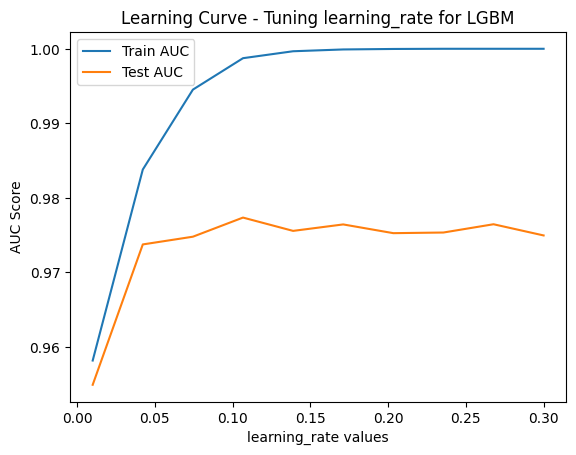


Learning curve for best_lgb (tuned):
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13882
[LightGBM] [Info] Number of data points in the train set: 15929, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502417 -> initscore=0.009668
[LightGBM] [Info] Start training from score 0.009668
learning_rate value: 0.01; train AUC: 0.9836513963080147; test AUC: 0.9731556100378601
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8003, number of negative: 7926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_col_wise=true` to remove the ove

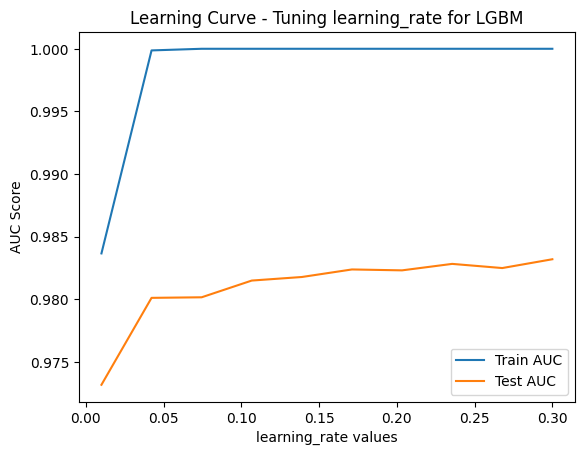

In [40]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def draw_learning_curve(param_values, base_model, param_name='learning_rate'):
    train_scores = []
    test_scores = []

    # Get the base parameters from the model (lgb or best_lgb)
    base_params = base_model.get_params()

    for value in param_values:
        # Create a new model using the base parameters, adjusting only the specified parameter
        model_params = {**base_params, param_name: value}
        model = LGBMClassifier(**model_params)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate on the training set
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:, 1])
        train_scores.append(train_auc)

        # Evaluate on the test set
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        test_scores.append(test_auc)

        print(f'{param_name} value: {value}; train AUC: {train_auc}; test AUC: {test_auc}')

    # Plotting the learning curve
    plt.plot(param_values, train_scores, label='Train AUC')
    plt.plot(param_values, test_scores, label='Test AUC')
    plt.xlabel(f'{param_name} values')
    plt.ylabel('AUC Score')
    plt.title(f'Learning Curve - Tuning {param_name} for LGBM')
    plt.legend()
    plt.show()

# Define the parameter values to test
param_values = [float(x) for x in np.linspace(0.01, 0.3, num=10)]  # Adjust range as needed

# Call the function using lgb and best_lgb as the base models
print("Learning curve for lgb (untuned):")
draw_learning_curve(param_values, lgb, param_name='learning_rate')

print("\nLearning curve for best_lgb (tuned):")
draw_learning_curve(param_values, best_lgb, param_name='learning_rate')

# Support Vector Machines (SVM) - SVC

## Home Credit

In [2]:
from IPython.display import Image, display

import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=150

In [3]:
application_train_inner_merged = pd.read_csv('application_train_inner_merged.csv')

In [4]:
application_train_inner_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Columns: 109 entries, SK_ID_CURR to AMT_PAYMENT_DIFFERENCES
dtypes: float64(57), int64(52)
memory usage: 9.2 MB


In [4]:
application_train_inner_merged.isnull().sum()

SK_ID_CURR                  0
TARGET                      0
NAME_CONTRACT_TYPE          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
                           ..
DAYS_INSTALMENT             0
DAYS_ENTRY_PAYMENT          0
AMT_INSTALMENT              0
DAYS_ENTRY_PAYMENT_RATIO    0
AMT_PAYMENT_DIFFERENCES     0
Length: 109, dtype: int64

In [5]:
application_train_inner_merged.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
11038    False
11039    False
11040    False
11041    False
11042    False
Length: 11043, dtype: bool

In [8]:
application_train_inner_merged.head(10)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100048       0                   0            0             0   
1      100135       0                   0            1             0   
2      100139       0                   0            0             0   
3      100180       0                   0            0             0   
4      100211       0                   0            1             0   
5      100231       0                   0            1             1   
6      100267       0                   0            1             0   
7      100302       0                   0            0             0   
8      100307       0                   0            1             0   
9      100321       0                   0            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
0                1         12.218495                6                 6   
1                1         11.813030                6                 1   
2                0         11.967181                1                 6   
3                1         12.660328                6                 1   
4                0         12.323856                6                 1   
5                1         11.589887                5                 1   
6                1         12.323856                6                 1   
7                1         12.100712                6                 6   
8                1         12.323856                6                 4   
9                0         12.506177                6                 1   

   NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                    4                   1                  1   
1                    4                   1                  1   
2                    4                   1                  1   
3                    1                   1                  1   
4                    4                   1                  1   
5                    4                   1                  1   
6                    1                   1                  1   
7                    4                   0                  1   
8                    4                   1                  1   
9                    4                   0                  1   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.009175      -16971           -475            -3148.0   
1                    0.007330      -19829           -215            -4730.0   
2                    0.010276      -13286          -2305            -6685.0   
3                    0.020713      -15581          -4940            -9520.0   
4                    0.006233      -14033           -328             -544.0   
5                    0.018634      -17850          -2899            -2880.0   
6                    0.026392      -13685          -3281            -7727.0   
7                    0.019689       -9105           -482            -5874.0   
8                    0.018850      -16546          -1480            -2196.0   
9                    0.019689      -13534          -1420            -1602.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -513         -1.0               1                0   
1            -3368         -1.0               1                0   
2            -4955         -1.0               1                0   
3            -5239         -1.0               1                0   
4             -554         -1.0               1                1   
5            -1400          9.0               1                0   
6            -4477         -1.0               1                1   
7            -1139         -1.0               1                0   
8               -7         -1.0               1                0   
9            -4133          1.0               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  OCCU

In [9]:
list_item = []
for col in application_train_inner_merged.columns:
    list_item.append([col, application_train_inner_merged[col].dtype, application_train_inner_merged[col].isna().sum(),
                      100 * application_train_inner_merged[col].isna().sum() / len(application_train_inner_merged[col]),
                      application_train_inner_merged[col].nunique(), application_train_inner_merged[col].unique()])
desc_df = pd.DataFrame(data=list_item,
                       columns=['feature', 'data_type', 'null_num', 'null_persen', 'unique_num', 'unique_sample'])
desc_df

feature data_type  null_num  null_persen  unique_num  \
0                  SK_ID_CURR     int64         0          0.0       11043   
1                      TARGET     int64         0          0.0           2   
2          NAME_CONTRACT_TYPE     int64         0          0.0           2   
3                 CODE_GENDER     int64         0          0.0           2   
4                FLAG_OWN_CAR     int64         0          0.0           2   
..                        ...       ...       ...          ...         ...   
104           DAYS_INSTALMENT   float64         0          0.0       10881   
105        DAYS_ENTRY_PAYMENT   float64         0          0.0       10985   
106            AMT_INSTALMENT   float64         0          0.0       11038   
107  DAYS_ENTRY_PAYMENT_RATIO   float64         0          0.0       11039   
108   AMT_PAYMENT_DIFFERENCES   float64         0          0.0        6818   

                                         unique_sample  
0    [100048, 100135, 100139, 100180, 100211, 10023...  
1                                               [0, 1]  
2                                               [0, 1]  
3                                               [0, 1]  
4                                               [0, 1]  
..                                                 ...  
104  [0.7681197660078626, 0.6593632567283305, -0.06...  
105  [0.7762681251569803, 0.6373330213573201, -0.06...  
106  [7.821249522939979, 9.684912748956602, 8.78819...  
107  [-0.000707695986899, 0.0617072724990601, 0.016...  
108  [0.1884086956475151, 0.066423731097917, -1.224...  

[109 rows x 6 columns]

**Outliers Data**

In [13]:
plt.figure(figsize=(100, 80))

for i, column in enumerate(application_train_inner_merged.columns):
    plt.subplot(len(application_train_inner_merged.columns)//3 + 1, 3, i + 1)  # Menyesuaikan grid
    sns.boxplot(data=application_train_inner_merged, y=column)  # Membuat boxplot untuk kolom
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()

### **Distribution Data**

In [16]:
import matplotlib.pyplot as plt

n_cols = 4
n_rows = (application_train_inner_merged.select_dtypes(include=['float64', 'int64']).shape[1] + n_cols - 1) // n_cols 

# Buat subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(100, 80))
fig.suptitle('Histograms of Application Train', fontsize=16)

# Loop untuk plot setiap fitur numerik
for i, column in enumerate(application_train_inner_merged.select_dtypes(include=['float64', 'int64']).columns):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].hist(application_train_inner_merged[column].dropna(), bins=50)
    axes[row, col].set_title(column)

# Hapus subplot yang kosong (jika ada)
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **Default Rate**

In [17]:
import pandas as pd

# nama dataframe = application_train_inner_merged

# Hitung total peminjam
total_peminjam = len(application_train_inner_merged)

# Hitung jumlah peminjam yang default (TARGET = 1)
jumlah_default = application_train_inner_merged['TARGET'].sum()

# Hitung default rate
default_rate = (jumlah_default / total_peminjam) * 100

print(f'Default Rate: {default_rate:.2f}%')

Default Rate: 9.84%


* **Default Rate: 9.84%** <br>
Berarti sekitar 9.84% dari total nasabah dalam dataset mengalami default (TARGET = 1), <br>
sementara sisanya (sekitar 90.16%) tidak mengalami default (TARGET = 0).

### **Distribusi kelas target**

In [18]:
# Menghitung berapa banyak jumlah 0 dan 1 pada TARGET

target_counts = application_train_inner_merged['TARGET'].value_counts()
print(target_counts)

TARGET
0    9956
1    1087
Name: count, dtype: int64


### **Proporsi target 0 dan 1**

In [19]:
# Untuk mengetahui ketidakseimbangan data

target_proportions = application_train_inner_merged['TARGET'].value_counts(normalize=True)
print(target_proportions)

TARGET
0    0.901567
1    0.098433
Name: proportion, dtype: float64


## Split Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
application_train_inner_merged = pd.read_csv('application_train_inner_merged.csv')

# Pisahkan target dan fitur
X = application_train_inner_merged.drop(columns=['TARGET'])  # Fitur
y = application_train_inner_merged['TARGET']  # Target

# Split data menjadi data training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8834, 108)
Testing data size: (2209, 108)


## **Data Pre-processing**

### 1. Handling Outliers

In [4]:
def handle_outliers_iqr(df):
    # Menangani outliers untuk semua fitur numerik di df
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Menghitung Q1 dan Q3 untuk setiap kolom
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Tentukan batas bawah dan atas untuk outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Ganti nilai outliers dengan batas bawah atau atas
        df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
    return df

# Menangani outliers pada data training (X_train)
X_train = handle_outliers_iqr(X_train)

# Menangani outliers pada data testing (X_test) jika diperlukan
X_test = handle_outliers_iqr(X_test)

# Menampilkan beberapa data setelah penanganan outliers
print(X_train.head())

      SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
9489      403942                 0.0            0             0   
1349      144346                 0.0            1             0   
2464      180890                 0.0            0             0   
2270      174884                 0.0            0             0   
8192      364054                 0.0            0             1   

      FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
9489                0         12.049419              6.0                 6   
1349                1         12.323856              6.0                 6   
2464                1         12.240474              6.0                 1   
2270                1         11.407565              6.0                 6   
8192                1         11.967181              6.0                 6   

      NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
9489                    4                 1.0               

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Scaling the features for better SVM performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create the SVM model with class weight adjustment
svm_model = SVC(kernel='linear', class_weight=class_weight_dict, random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Displaying evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.6655
Precision: 0.1658
Recall: 0.6552
F1-Score: 0.2647
ROC-AUC: 0.6608
Confusion Matrix:
[[1337  669]
 [  70  133]]


* Accuracy: 0.6655 <br>
Model ini memiliki tingkat akurasi sekitar 66.55%. Artinya, 66.55% dari prediksi model adalah benar (baik untuk kelas 0 maupun 1). Akurasi ini termasuk rendah.<br>
<br>
* Precision: 0.1658 <br>
Precision adalah rasio prediksi positif yang benar. Precision yang rendah (16.58%) menunjukkan bahwa model Anda sering memprediksi "default" (TARGET=1), tetapi banyak dari prediksi tersebut yang salah (false positives). <br>
<br>
* Recall: 0.6552 <br>
Recall mengukur sejauh mana model dapat menangkap kasus "default" (TARGET=1). Nilai recall sebesar 65.52% menunjukkan bahwa model berhasil menangkap sebagian besar kasus default, namun masih ada yang tidak terdeteksi (false negatives). <br>
<br>
* F1-Score: 0.2647 <br>
F1-Score adalah rata-rata harmonis dari precision dan recall. F1-Score yang rendah ini mengindikasikan bahwa meskipun recall cukup tinggi, precision sangat rendah, yang membuat keseimbangan antara keduanya buruk. <br>
<br>
* ROC-AUC: 0.6608 <br>
Area under the curve (AUC) dari receiver operating characteristic (ROC) adalah 0.6608, yang menunjukkan model memiliki kemampuan yang cukup baik untuk membedakan antara kelas positif dan negatif, meskipun masih ada banyak ruang untuk perbaikan. <br>
<br>
* Confusion Matrix: <br>
    Baris pertama menunjukkan kelas 0 (non-default):<br>
    1337 benar diprediksi sebagai non-default (True Negatives).<br>
    669 salah diprediksi sebagai default (False Positives).

    Baris kedua menunjukkan kelas 1 (default):<br>
    70 salah diprediksi sebagai non-default (False Negatives).<br>
    133 benar diprediksi sebagai default (True Positives).

In [22]:
from sklearn.svm import SVC

# Membuat model SVC dengan probability=True
svm_model = SVC(probability=True)

# Latih model dengan data training
svm_model.fit(X_train, y_train)

# Mendapatkan probabilitas prediksi untuk kelas 1 (default)
y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Tentukan ambang batas (threshold) 0.5 untuk klasifikasi default (TARGET=1)
y_pred_default = (y_pred_prob >= 0.5).astype(int)

# Hitung default rate berdasarkan prediksi
default_rate_predicted = np.mean(y_pred_default)
print(f"Default Rate pada Data Prediksi: {default_rate_predicted * 100:.2f}%")

Default Rate pada Data Prediksi: 0.00%


In [9]:
# Lihat nilai prediksi probabilitas
print(y_pred_prob[:10])  # Menampilkan 10 nilai pertama prediksi probabilitas

[0.09188436 0.09188428 0.09188437 0.09188422 0.09188437 0.09188448
 0.09188449 0.09188404 0.09188405 0.09188444]


* Probabilitas prediksi sangat rendah (sekitar 0.09). Ini berarti model hampir tidak memprediksi "default" sama sekali, mengarah pada threshold yang sangat tinggi dan akhirnya mengklasifikasikan semua sampel sebagai non-default. <br>
* Dalam hal ini, ambang batas (threshold) 0.5 yang digunakan untuk mengklasifikasikan kelas 1 (default) sangat ketat, sehingga tidak ada satu pun prediksi yang menjadi kelas 1. <br>
* Threshold telah diuji dari 0.9 hingga 0.2 namun tetap menghasilkan prediksi 0.00%. Maka kemungkinan besar masalahnya terletak pada probabilitas prediksi model yang sangat rendah untuk kelas 1 (default). <br>
* Model hampir selalu memprediksi kelas 0 (non-default) untuk semua sampel. <br>
* Model tidak cukup belajar untuk memisahkan kelas default (1) dan non-default (0) dengan baik. <br>
* Class imbalance yang berat, di mana kelas 1 (default) sangat jarang dibandingkan dengan kelas 0 (non-default), sehingga model sangat cenderung memprediksi kelas 0.

In [11]:
y_pred_default = (y_pred_prob >= 0.5).astype(int)
y_pred_default

array([0, 0, 0, ..., 0, 0, 0])

### 2. Handling Class Imbalance (SMOTE)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
application_train_inner_merged = pd.read_csv('application_train_inner_merged.csv')

# Pisahkan target dan fitur
X = application_train_inner_merged.drop(columns=['TARGET'])  # Fitur
y = application_train_inner_merged['TARGET']  # Target

# Split data menjadi data training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

In [5]:
# Import libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Mengaplikasikan SMOTE pada data train
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Melihat distribusi kelas setelah SMOTE
print("Distribusi kelas sebelum SMOTE:", y_train.value_counts())
print("Distribusi kelas setelah SMOTE:", y_train_smote.value_counts())

Distribusi kelas sebelum SMOTE: TARGET
0    7950
1     884
Name: count, dtype: int64
Distribusi kelas setelah SMOTE: TARGET
1    7950
0    7950
Name: count, dtype: int64


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Menstandarisasi data (scaling) untuk SVM
scaler = StandardScaler()

# Scaling X_train_smote dan X_test
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)  # Asumsi X_test sudah ada

# Membuat model SVM dengan class_weight='balanced' untuk menangani class imbalance
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

# Melatih model dengan data train yang sudah di-resample dengan SMOTE
svm_model.fit(X_train_smote_scaled, y_train_smote)

# Membuat prediksi pada data test
y_pred = svm_model.predict(X_test_scaled)

# Mendapatkan probabilitas prediksi untuk kelas 1 (default)
y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Menentukan threshold 0.5 untuk klasifikasi default (TARGET=1)
y_pred_default = (y_pred_prob >= 0.5).astype(int)

# Menghitung default rate berdasarkan prediksi
default_rate_predicted = np.mean(y_pred_default)
print(f"Default Rate pada Data Prediksi: {default_rate_predicted * 100:.2f}%")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Default Rate pada Data Prediksi: 6.61%
Accuracy: 0.8692
Precision: 0.1838
Recall: 0.1232
F1-Score: 0.1475
ROC-AUC: 0.6210
Confusion Matrix:
[[1895  111]
 [ 178   25]]


### 3. Handling Class Imbalance (SMOTE) & IQR

In [ ]:
# Import libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Memisahkan fitur (X) dan target (y)
X = application_train_inner_merged.drop('target', axis=1)  # Gantilah 'target' dengan nama kolom target di dataset kamu
y = application_train_inner_merged['target']

# Membagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def handle_outliers_iqr(df):
    # Menangani outliers untuk semua fitur numerik di df
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Menghitung Q1 dan Q3 untuk setiap kolom
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Tentukan batas bawah dan atas untuk outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Ganti nilai outliers dengan batas bawah atau atas
        df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
    return df

# Menangani outliers pada data training (X_train)
X_train = handle_outliers_iqr(X_train)

# Menangani outliers pada data testing (X_test) jika diperlukan
X_test = handle_outliers_iqr(X_test)

# Menampilkan beberapa data setelah penanganan outliers
print(X_train.head())

In [24]:
# Mengaplikasikan SMOTE pada data train
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Melihat distribusi kelas setelah SMOTE
print("Distribusi kelas sebelum SMOTE:", y_train.value_counts())
print("Distribusi kelas setelah SMOTE:", y_train_smote.value_counts())

Distribusi kelas sebelum SMOTE: TARGET
0    7950
1     884
Name: count, dtype: int64
Distribusi kelas setelah SMOTE: TARGET
1    7950
0    7950
Name: count, dtype: int64


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Menstandarisasi data (scaling) untuk SVM
scaler = StandardScaler()

# Scaling X_train_smote dan X_test
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)  # Asumsi X_test sudah ada

# Membuat model SVM dengan class_weight='balanced' untuk menangani class imbalance
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

# Melatih model dengan data train yang sudah di-resample dengan SMOTE
svm_model.fit(X_train_smote_scaled, y_train_smote)

# Membuat prediksi pada data test
y_pred = svm_model.predict(X_test_scaled)

# Mendapatkan probabilitas prediksi untuk kelas 1 (default)
y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Menentukan threshold 0.5 untuk klasifikasi default (TARGET=1)
y_pred_default = (y_pred_prob >= 0.5).astype(int)

# Menghitung default rate berdasarkan prediksi
default_rate_predicted = np.mean(y_pred_default)
print(f"Default Rate pada Data Prediksi: {default_rate_predicted * 100:.2f}%")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Default Rate pada Data Prediksi: 6.29%
Accuracy: 0.8796
Precision: 0.2734
Recall: 0.1872
F1-Score: 0.2222
ROC-AUC: 0.6342
Confusion Matrix:
[[1905  101]
 [ 165   38]]


### 4. Hyperparameter Tuning

In [7]:
# Import libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Memisahkan fitur (X) dan target (y)
X = application_train_inner_merged.drop('TARGET', axis=1)  # Gantilah 'target' dengan nama kolom target di dataset kamu
y = application_train_inner_merged['TARGET']

# Membagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
def handle_outliers_iqr(df):
    # Menangani outliers untuk semua fitur numerik di df
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Menghitung Q1 dan Q3 untuk setiap kolom
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Tentukan batas bawah dan atas untuk outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Ganti nilai outliers dengan batas bawah atau atas
        df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
    return df

# Menangani outliers pada data training (X_train)
X_train = handle_outliers_iqr(X_train)

# Menangani outliers pada data testing (X_test) jika diperlukan
X_test = handle_outliers_iqr(X_test)

# Menampilkan beberapa data setelah penanganan outliers
print(X_train.head())

       SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
7822       353124                 0.0            0             0   
10879      451187                 0.0            1             1   
1600       152966                 0.0            1             1   
8819       382902                 0.0            1             1   
7698       349870                 0.0            1             1   

       FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
7822                 0         11.407565              6.0                 6   
10879                1         11.967181              6.0                 6   
1600                 1         12.660328              6.0                 1   
8819                 0         12.323856              6.0                 1   
7698                 1         12.196022              6.0                 1   

       NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
7822                     4                 1.0 

In [9]:
# Mengaplikasikan SMOTE pada data train
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Melihat distribusi kelas setelah SMOTE
print("Distribusi kelas sebelum SMOTE:", y_train.value_counts())
print("Distribusi kelas setelah SMOTE:", y_train_smote.value_counts())

Distribusi kelas sebelum SMOTE: TARGET
0    6980
1     750
Name: count, dtype: int64
Distribusi kelas setelah SMOTE: TARGET
0    6980
1    6980
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
import numpy as np

# Menstandarisasi data (scaling) untuk SVM
scaler = StandardScaler()

# Scaling X_train_smote dan X_test
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)  # Asumsi X_test sudah ada

# Menentukan distribusi parameter yang ingin diuji pada RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 100),  # Rentang nilai untuk parameter regulasi C
    'kernel': ['linear', 'rbf', 'poly'],  # Jenis kernel
    'gamma': ['scale', 'auto', 0.1, 1],  # Parameter gamma
    'class_weight': ['balanced', None],  # Menangani class imbalance
}

# Membuat model SVM
svm_model = SVC(probability=True, random_state=42)

# Membuat RandomizedSearchCV untuk mencari hyperparameter terbaik
random_search = RandomizedSearchCV(
    svm_model, param_distributions, n_iter=10, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)

# Melatih model dengan data train yang sudah di-resample dengan SMOTE
random_search.fit(X_train_smote_scaled, y_train_smote)

# Mendapatkan model terbaik dari RandomizedSearchCV
best_svm_model = random_search.best_estimator_

# Menampilkan hasil RandomizedSearchCV
print("Best Hyperparameters from RandomizedSearchCV:", random_search.best_params_)

# Membuat prediksi pada data test menggunakan model terbaik
y_pred = best_svm_model.predict(X_test_scaled)

# Mendapatkan probabilitas prediksi untuk kelas 1 (default)
y_pred_prob = best_svm_model.predict_proba(X_test_scaled)[:, 1]

# Menentukan threshold 0.5 untuk klasifikasi default (TARGET=1)
y_pred_default = (y_pred_prob >= 0.5).astype(int)

# Menghitung default rate berdasarkan prediksi
default_rate_predicted = np.mean(y_pred_default)
print(f"Default Rate pada Data Prediksi: {default_rate_predicted * 100:.2f}%")

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Best Hyperparameters from RandomizedSearchCV: {'C': 5.741157902710025, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}
Default Rate pada Data Prediksi: 0.00%
Accuracy: 0.8983
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5412
Confusion Matrix:
[[2976    0]
 [ 337    0]]


## **Result**

In [1]:
import pandas as pd

results = pd.DataFrame(columns=["Tindakan", "Model", "Default Rate", "Accuracy",
                                "Precision", "Recall", "F1-Score",
                                "ROC-AUC", "Confusion Metrix", "Keputusan"]) 

In [2]:
# 1.Data Mentah (Raw Data)
results = pd.concat([results, pd.DataFrame([{
    "Tindakan": 'Data Asli',
    "Model": '-',
    "Default Rate": '9.84%',
    "Accuracy": '-',
    "Precision": '-',
    "Recall": '-',
    "F1-Score": '-',
    "ROC-AUC": '-',
    "Confusion Metrix": '-',
    "Keputusan": 'Dilanjutkan uji coba permodelan'}])], ignore_index=True)

# 2.Handling Outliers (IQR)
results = pd.concat([results, pd.DataFrame([{
    "Tindakan": 'Handling Outliers (IQR)',
    "Model": 'Support Vector Machines (SVM) - SVC',
    "Default Rate": '0.00%',
    "Accuracy": '0.6655',
    "Precision": '0.1658',
    "Recall": '0.6552',
    "F1-Score": '0.2647',
    "ROC-AUC": '0.6608',
    "Confusion Metrix": 'TN:1337, FP:669, FN:70, TP:133',
    "Keputusan": 'Dilanjutkan uji coba permodelan'}])], ignore_index=True)

# 3.Handling Class Imbalance (SMOTE)
results = pd.concat([results, pd.DataFrame([{
    "Tindakan": 'Handling Class Imbalance (SMOTE)',
    "Model": 'Support Vector Machines (SVM) - SVC',
    "Default Rate": '6.61%',
    "Accuracy": '0.8692',
    "Precision": '0.1838',
    "Recall": '0.1232',
    "F1-Score": '0.1475',
    "ROC-AUC": '0.6210',
    "Confusion Metrix": 'TN:1895, FP:111, FN:178, TP:25',
    "Keputusan": 'Dilanjutkan uji coba permodelan'}])], ignore_index=True)

# 4.Handling Outliers (IQR) & Handling Class Imbalance (SMOTE)
results = pd.concat([results, pd.DataFrame([{
    "Tindakan": 'IQR & Handling Class Imbalance (SMOTE)',
    "Model": 'Support Vector Machines (SVM) - SVC',
    "Default Rate": '6.29%',
    "Accuracy": '0.8796',
    "Precision": '0.2734',
    "Recall": '0.1872',
    "F1-Score": '0.2222',
    "ROC-AUC": '0.6342',
    "Confusion Metrix": 'TN:1905, FP:101, FN:165, TP:38',
    "Keputusan": 'Diterima dan diterapkan untuk proses uji coba model selanjutnya'}])], ignore_index=True)

# 5.Hyperparameter Tuning
results = pd.concat([results, pd.DataFrame([{
    "Tindakan": 'IQR, SMOTE & Hyperparameter Tuning',
    "Model": 'Support Vector Machines (SVM) - SVC, Tuning: RandomizedSearchCV',
    "Default Rate": '0.00%',
    "Accuracy": '0.8983',
    "Precision": '0.0000',
    "Recall": '0.0000',
    "F1-Score": '0.0000',
    "ROC-AUC": '0.5412',
    "Confusion Metrix": 'TN:2976, FP:0, FN:337, TP:0',
    "Keputusan": 'Lebih baik tidak dilakukan hyperparameter tuning'}])], ignore_index=True)


# Membuat DataFrame
results_df = pd.DataFrame(results)

# Menampilkan DataFrame dengan style untuk tabel yang lebih rapi
results_styled = results_df.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'padding': '10px'
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}
])

# Menampilkan tabel dengan style (jika di Jupyter Notebook)
results_styled

# Logistics Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from matplotlib import rcParams
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from imblearn import under_sampling, over_sampling

In [2]:
df = pd.read_csv('application_train_inner_merged.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Columns: 109 entries, SK_ID_CURR to AMT_PAYMENT_DIFFERENCES
dtypes: float64(57), int64(52)
memory usage: 9.2 MB


In [ ]:
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

AMT_CREDIT_MAX_OVERDUE                1
CNT_CREDIT_PROLONG                    1
AMT_CREDIT_SUM_DEBT                   1
AMT_CREDIT_SUM_LIMIT                  1
AMT_CREDIT_SUM_OVERDUE                1
DAYS_CREDIT_UPDATE                    1
AMT_ANNUITY                           1
STATUS                                1
CREDIT_TYPE_Encoded                   1
NAME_PRODUCT_TYPE_walk-in             1
NAME_CONTRACT_STATUS_Refused_x        1
CODE_REJECT_REASON_SCOFR              1
AMT_BALANCE                           1
AMT_CREDIT_LIMIT_ACTUAL               1
AMT_INST_MIN_REGULARITY               1
AMT_PAYMENT_CURRENT                   1
AMT_PAYMENT_TOTAL_CURRENT             1
AMT_TOTAL_RECEIVABLE                  1
UTILIZATION_RATE                      1
PAYMENT_TO_BALANCE_RATIO              1
Regularization                        1
NAME_CONTRACT_STATUS_Active           1
NAME_CONTRACT_STATUS_Approved         1
NAME_CONTRACT_STATUS_Completed        1
NAME_CONTRACT_STATUS_Demand           1


In [ ]:
nan_columns = df.columns[df.isna().any()].tolist()
print('Kolom yang memiliki missing values', nan_columns)

Kolom yang memiliki missing values []


In [ ]:
df.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100048       0                   0            0             0   
1      100135       0                   0            1             0   
2      100139       0                   0            0             0   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
0                1         12.218495                6                 6   
1                1         11.813030                6                 1   
2                0         11.967181                1                 6   

   NAME_EDUCATION_TYPE  ...  NAME_CONTRACT_STATUS_Signed  MONTHS_BALANCE  \
0                    4  ...                          0.0        1.266472   
1                    4  ...                          0.0        1.266472   
2                    4  ...                          0.0        1.266472   

   MONTHS_BALANCE.1  CNT_INSTALMENT_LOG  CNT_INSTALMENT_LOG.1  \
0          0.767749            0.043016              0.688250   
1         -0.191334            0.215436              6.032220   
2         -1.917683           -0.965957            -33.808493   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0         0.768120            0.776268        7.821250   
1         0.659363            0.637333        9.684913   
2        -0.069429           -0.064093        8.788192   

   DAYS_ENTRY_PAYMENT_RATIO  AMT_PAYMENT_DIFFERENCES  
0                 -0.000708                 0.188409  
1                  0.061707                 0.188409  
2                  0.016936                 0.066424  

[3 rows x 109 columns]

In [ ]:
list_item = []
for col in df.columns:
    list_item.append([col, df[col].dtype, df[col].isna().sum(),
                      100 * df[col].isna().sum() / len(df[col]),
                      df[col].nunique(), df[col].unique()])
desc_df = pd.DataFrame(data=list_item,
                       columns=['feature', 'data_type', 'null_num', 'null_persen', 'unique_num', 'unique_sample'])
desc_df

feature data_type  null_num  null_persen  unique_num  \
0                  SK_ID_CURR     int64         0     0.000000       10075   
1                      TARGET     int64         0     0.000000           2   
2          NAME_CONTRACT_TYPE     int64         0     0.000000           2   
3                 CODE_GENDER     int64         0     0.000000           2   
4                FLAG_OWN_CAR     int64         0     0.000000           2   
..                        ...       ...       ...          ...         ...   
104           DAYS_INSTALMENT   float64         1     0.009926        9933   
105        DAYS_ENTRY_PAYMENT   float64         1     0.009926       10026   
106            AMT_INSTALMENT   float64         1     0.009926       10071   
107  DAYS_ENTRY_PAYMENT_RATIO   float64         1     0.009926       10070   
108   AMT_PAYMENT_DIFFERENCES   float64         1     0.009926        6212   

                                         unique_sample  
0    [100048, 100135, 100139, 100180, 100211, 10023...  
1                                               [0, 1]  
2                                               [0, 1]  
3                                               [0, 1]  
4                                               [0, 1]  
..                                                 ...  
104  [0.7681197660078626, 0.6593632567283305, -0.06...  
105  [0.7762681251569803, 0.6373330213573201, -0.06...  
106  [7.821249522939979, 9.684912748956602, 8.78819...  
107  [-0.000707695986899, 0.0617072724990601, 0.016...  
108  [0.1884086956475151, 0.066423731097917, -1.224...  

[109 rows x 6 columns]

MODELLING

In [22]:
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

In [23]:
from imblearn.over_sampling import SMOTE

resampling = SMOTE(sampling_strategy = 'minority', random_state = 42)
X, y  = resampling.fit_resample(X, y)

y.value_counts()

TARGET
0    9956
1    9956
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred             = model.predict(X_valid)
    y_pred_train       = model.predict(X_train)
    y_pred_proba       = model.predict_proba(X_valid)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (Train Set)    : %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set)     : %.2f' % accuracy_score(y_valid, y_pred))

    print('Precision (Train Set)   : %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test Set)    : %.2f' % precision_score(y_valid, y_pred))

    print('Recall (Train Set)      : %.2f' % recall_score(y_train, y_pred_train))
    print('Recall (Test Set)       : %.2f' % recall_score(y_valid, y_pred))

    print('F1-Score (Train Set)    : %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test Set)     : %.2f' % f1_score(y_valid, y_pred))

    print('ROC-AUC (Train-Proba)   : %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC (Test-Proba)    : %.2f' % roc_auc_score(y_valid, y_pred_proba[:, 1]))

    score = cross_validate(model, X, y, cv = 5, scoring = 'recall', return_train_score = True)
    print('Recall (Crossval Train) : ' + str(score['train_score'].mean().round(2)))
    print('Recall (Crossval Test)  : ' + str(score['test_score'].mean().round(2)))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    ax = feat_importances.nlargest(25).plot(kind = 'barh', figsize = (10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [25]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
eval_classification(logreg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Train Set)    : 0.56
Accuracy (Test Set)     : 0.58
Precision (Train Set)   : 0.57
Precision (Test Set)    : 0.58
Recall (Train Set)      : 0.52
Recall (Test Set)       : 0.53
F1-Score (Train Set)    : 0.54
F1-Score (Test Set)     : 0.55
ROC-AUC (Train-Proba)   : 0.61
ROC-AUC (Test-Proba)    : 0.62


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Recall (Crossval Train) : 0.51
Recall (Crossval Test)  : 0.51


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Setelah dilakukan Penanganan Oversampling, maka didapatkan nilai-nilai tersebut:


Berikut Penjelasan Hasil:
* Accuracy (Train Set) dan Accuracy (Test Set):
Accuracy di Train Set adalah 0.56, dan di Test Set adalah 0.58. Accuracy masih dikatakan tinggi. Hal ini menunjukkan bahwa model belum cukup baik dikarenakan msih dibawah batas ambang 0.7.

* Precision (Train Set) dan Precision (Test Set):
Precision (Train Set): 0.57, Precision (Test Set): 0.58.
Precision mengukur berapa banyak prediksi positif yang benar-benar positif. Angka yang  rendah ini menunjukkan bahwa model masih banyak menghasilkan False Positives.Sehingga Model dikatakan tidak berhasil dengan baik dalam mengidentifikasi prediksi positif yang benar.

* Recall (Train Set) dan Recall (Test Set):
Recall (Train Set): 0.52, Recall (Test Set): 0.53.
Recall mengukur berapa banyak data positif yang berhasil diprediksi dengan benar oleh model. Nilai tersebut masih rendah, yang menunjukkan bahwa model masih kurang berhasil dalam mengidentifikasi sebagian besar data positif.

* F1-Score (Train Set) dan F1-Score (Test Set):
F1-Score (Train Set): 0.54, F1-Score (Test Set): 0.55.
F1-Score adalah rata-rata harmonis antara Precision dan Recall. Karena keduanya sangat rendah, F1-Score juga sangat rendah. Ini menunjukkan bahwa model tidak dapat memberikan prediksi yang baik pada kelas positif secara keseluruhan.

* ROC-AUC (Train-Proba) dan ROC-AUC (Test-Proba):
ROC-AUC (Train-Proba): 0.61, ROC-AUC (Test-Proba): 0.59.
ROC-AUC mengukur area di bawah kurva ROC, yang memberikan gambaran tentang kemampuan model dalam membedakan kelas positif dan negatif. Nilai 0.61 (train) dan 0.59 (test) menunjukkan bahwa model memiliki sedikit kemampuan untuk membedakan kelas positif dan negatif, tetapi tidak cukup baik.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.00014, 0.000145, 50)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression(class_weight='balanced', max_iter=200)
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=50)
rs.fit(X_train_over, y_train_over)
eval_classification(rs)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy (Train Set)    : 0.61
Accuracy (Test Set)     : 0.59
Precision (Train Set)   : 0.13
Precision (Test Set)    : 0.12
Recall (Train Set)      : 0.52
Recall (Test Set)       : 0.48
F1-Score (Train Set)    : 0.20
F1-Score (Test Set)     : 0.20
ROC-AUC (Train-Proba)   : 0.61
ROC-AUC (Test-Proba)    : 0.59


Streaming output truncated to the last 5000 lines.
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm

Recall (Crossval Train) : 0.49
Recall (Crossval Test)  : 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_valid)
        test_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001; train: 0.6087353250605714; test: 0.6163489793396038


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010101010101010101; train: 0.6085194868729678; test: 0.6163315752700783


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010202020202020203; train: 0.6085030913054337; test: 0.6157950759094888


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010303030303030303; train: 0.6086962752328966; test: 0.616131806819873


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010404040404040404; train: 0.6084600687056259; test: 0.6163388900239369


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010505050505050506; train: 0.6086912935027614; test: 0.6164032094113137


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010606060606060606; train: 0.608609709789311; test: 0.6168645433701845


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010707070707070707; train: 0.6085832719366624; test: 0.6162912180074106


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010808080808080809; train: 0.6084842521677384; test: 0.6162536353065512


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00010909090909090909; train: 0.6085689888749453; test: 0.6162854166509022


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011010101010101011; train: 0.6085598294280826; test: 0.6162632201564348


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011111111111111112; train: 0.6084884771793722; test: 0.6162231151266587


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011212121212121212; train: 0.6084610303687215; test: 0.6161754431101325


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011313131313131314; train: 0.6086675356948059; test: 0.616488716361591


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011414141414141415; train: 0.6087778116514407; test: 0.6166049957246524


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011515151515151515; train: 0.6085806549518444; test: 0.6163840397115464


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011616161616161617; train: 0.6085604600268338; test: 0.61627154384186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00011717171717171717; train: 0.6085431343261417; test: 0.6161663627260323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001181818181818182; train: 0.6085773285434314; test: 0.6162074766873751


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001191919191919192; train: 0.6084984721695803; test: 0.6161953695085747


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001202020202020202; train: 0.6086056424273649; test: 0.6163530150658706


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012121212121212122; train: 0.608152541459582; test: 0.6165283169255837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012222222222222224; train: 0.6081173855791966; test: 0.616748264007123


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012323232323232323; train: 0.6084652396153865; test: 0.6163716802998545


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012424242424242425; train: 0.6087228707352331; test: 0.6165956631076606


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012525252525252524; train: 0.6084142241764058; test: 0.6161903248507412


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012626262626262626; train: 0.6085877018928904; test: 0.6161830100968826


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00012727272727272728; train: 0.608546886388712; test: 0.6163030729533192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001282828282828283; train: 0.6085463188498358; test: 0.6163214859544115


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001292929292929293; train: 0.608518004965902; test: 0.6163494838053872


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001303030303030303; train: 0.6086575407045977; test: 0.615805669690939


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001313131313131313; train: 0.6085191085137169; test: 0.6162417803606426


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013232323232323232; train: 0.6087588621589639; test: 0.6162566621012513


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013333333333333334; train: 0.6085589308248619; test: 0.6163121533374195


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013434343434343436; train: 0.6084470783713488; test: 0.6163822740813047


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013535353535353535; train: 0.6085144263179885; test: 0.6162972715968108


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013636363636363637; train: 0.6084768583973793; test: 0.6156644192716019


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001373737373737374; train: 0.6085310741250229; test: 0.6162362312370258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00013838383838383838; train: 0.6086709724580005; test: 0.616525794596667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001393939393939394; train: 0.6086356589279273; test: 0.6157635467980296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014040404040404042; train: 0.6083742126856353; test: 0.6157146136170448


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001414141414141414; train: 0.6086500996393323; test: 0.6157882656214136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014242424242424243; train: 0.6085371121080667; test: 0.6163504927369539


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014343434343434345; train: 0.6085978860627239; test: 0.6162516174434178


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014444444444444444; train: 0.6085118566280768; test: 0.6162566621012513


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014545454545454546; train: 0.6088832004677529; test: 0.6146020143318729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014646464646464648; train: 0.6084456279942208; test: 0.6162102512491835


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001474747474747475; train: 0.6081920642363202; test: 0.6160619383088792


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00014848484848484849; train: 0.6086656596635207; test: 0.6161900726178495


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001494949494949495; train: 0.6084598164661252; test: 0.6162950015007856


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001505050505050505; train: 0.6084965803733264; test: 0.6163719325327461


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015151515151515152; train: 0.6084706154697413; test: 0.6165023369377414


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015252525252525253; train: 0.6082285759040209; test: 0.6159315339038841


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015353535353535355; train: 0.6083248210384391; test: 0.6158826007228995


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015454545454545454; train: 0.6085106269605118; test: 0.6163023162546443


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015555555555555556; train: 0.6087084300238281; test: 0.6161817489324243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015656565656565655; train: 0.6084251965946784; test: 0.6159514603023264


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00015757575757575757; train: 0.6084320543560989; test: 0.6163941290272135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001585858585858586; train: 0.6085537283851636; test: 0.6160357060881454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001595959595959596; train: 0.608426678501744; test: 0.6160949808176885


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001606060606060606; train: 0.6084834166243929; test: 0.6164354952214478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016161616161616162; train: 0.6086219276401176; test: 0.6172673592981872


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001626262626262626; train: 0.6089509740685497; test: 0.6158588908310821


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016363636363636363; train: 0.6084723653812762; test: 0.6163530150658705


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016464646464646465; train: 0.6084507673740439; test: 0.6161391215737315


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016565656565656567; train: 0.6084873105716823; test: 0.6161673716575988


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001666666666666667; train: 0.608459548461656; test: 0.6158440090904734


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016767676767676768; train: 0.6085380895361313; test: 0.6157428637009122


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00016868686868686867; train: 0.6085239483591331; test: 0.6164743390867655


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001696969696969697; train: 0.6085941340001537; test: 0.616388327670705


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001707070707070707; train: 0.6086063203210227; test: 0.6158407300628816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017171717171717173; train: 0.6085709122011368; test: 0.6165146963494333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017272727272727275; train: 0.6083306698418575; test: 0.6162571665670347


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017373737373737374; train: 0.6082847622527623; test: 0.6166725941396209


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017474747474747476; train: 0.6086770104410442; test: 0.6164814016077323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017575757575757575; train: 0.6082711255547653; test: 0.6162412758948592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017676767676767677; train: 0.6084392116519262; test: 0.6159174088619505


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00017777777777777779; train: 0.6068001436125596; test: 0.6164130464940889


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001787878787878788; train: 0.6065561964856164; test: 0.6163124055703112


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001797979797979798; train: 0.6063427545732677; test: 0.6164206134808391


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018080808080808082; train: 0.6063610419370556; test: 0.616783072146174


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001818181818181818; train: 0.6064834096247467; test: 0.6167086634431304


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018282828282828283; train: 0.6061887308282609; test: 0.6165926363129604


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018383838383838384; train: 0.606516689473847; test: 0.6164418010437398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018484848484848486; train: 0.6086121375945035; test: 0.6162387535659425


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018585858585858588; train: 0.6065098159474578; test: 0.6168529406571676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018686868686868687; train: 0.6064346328113331; test: 0.6165621161330679


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018787878787878787; train: 0.6076417249410855; test: 0.6172777008467457


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00018888888888888888; train: 0.6062585538749994; test: 0.6168559674518677


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0001898989898989899; train: 0.6063227961227888; test: 0.617039592997006


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019090909090909092; train: 0.606863156192784; test: 0.6170443854219478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019191919191919194; train: 0.6084429794794654; test: 0.6166630092897374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019292929292929293; train: 0.6079206072388511; test: 0.6168458781362007


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019393939393939392; train: 0.6083711700466602; test: 0.6156671938334103


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019494949494949494; train: 0.6076578525041503; test: 0.6167533086649565


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019595959595959596; train: 0.608339119865125; test: 0.6170895351095573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00019696969696969698; train: 0.6086376610789627; test: 0.6165053637324415


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.000197979797979798; train: 0.6087635758846299; test: 0.6149791025049248


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.000198989898989899; train: 0.6089250564598709; test: 0.6168234294088417


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002; train: 0.6088158367561445; test: 0.6170675908479818


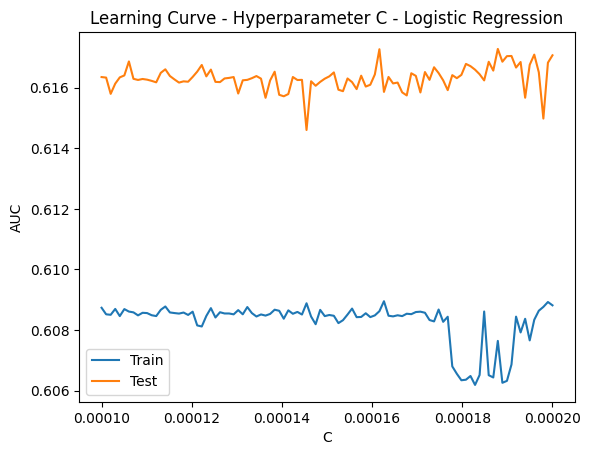

In [28]:
# learning curve
import numpy as np
param_values = [float(x) for x in np.linspace(0.0001, 0.0002, 100)]
draw_learning_curve(param_values)

Dari grafik tersebut ditunjukkan bahwa beberapa nilai C tidak akan menurunkan nilai AUC secara signifikan walaupun trend ini terlihat fluktuatif. Dapat dikataan model tidak mampu mengartikan dataset dengan baik.

Setelah dilakukan hyperparameter tuning dengan berbagai nilai C pada Logistic Regression, nilai ROC-AUC tetap berada di sekitar 0.60, ini menunjukkan bahwa model mungkin tidak mampu mengidentifikasi dengan baik perbedaan antara kelas positif dan negatif meskipun ada perubahan dalam nilai C.

Jadi kemungkinan besar penyebab nilai AUC rendah adalah **model yang tidak cukup kompleks untuk data**. Dikarenakan hubungan antar feature pada data yang memiliki hubungan yang kompleks dan linear. Maka disarankan menggunakan model yang lebih kompleks seperti Tree-Based.

Nilai C pada Logistic Regression adalah parameter regularisasi, yang mengontrol keseimbangan antara kesalahan training dan kompleksitas model:

* Nilai C yang besar (misalnya, C > 1) memberikan regularisasi yang lebih sedikit, yang berarti model cenderung lebih kompleks dan bisa lebih fit ke data train.
* Nilai C yang kecil (misalnya, C < 1) memberikan regularisasi yang lebih kuat, yang dapat menyebabkan model menjadi terlalu sederhana dan underfit, terutama pada data yang lebih kompleks.

Jika model tetap memberikan ROC-AUC sekitar 0.60 meskipun C sudah diuji dalam berbagai nilai, ini bisa menunjukkan bahwa model Logistic Regression mungkin tidak cukup kuat untuk menangani dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002; train: 0.6088158367561445; test: 0.6170675908479818


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020101010101010103; train: 0.6088303247624558; test: 0.6165338660492006


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020202020202020202; train: 0.6087085403786097; test: 0.616461727442182


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020303030303030304; train: 0.6083507386471179; test: 0.6165091472258165


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020404040404040406; train: 0.608405206614262; test: 0.6163290529411616


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020505050505050505; train: 0.6081709391781513; test: 0.616183514562666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020606060606060607; train: 0.6080171992025827; test: 0.616406740671797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002070707070707071; train: 0.6077900417673929; test: 0.6165121740205166


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00020808080808080808; train: 0.6074644478671243; test: 0.6164602140448319


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002090909090909091; train: 0.6079287577277118; test: 0.6164592051132652


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021010101010101012; train: 0.6077677973964406; test: 0.6164092630007139


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002111111111111111; train: 0.6074401225202926; test: 0.6168658045346429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021212121212121213; train: 0.6078752198937258; test: 0.6159867729071606


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021313131313131315; train: 0.6076155708578751; test: 0.6166683061804625


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021414141414141414; train: 0.607644657225279; test: 0.6167442282808563


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021515151515151516; train: 0.607746798458022; test: 0.616609283683811


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021616161616161617; train: 0.6075926643582339; test: 0.6161128893529975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021717171717171717; train: 0.6073706778328049; test: 0.6162725527734267


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00021818181818181818; train: 0.6076449725246548; test: 0.6155115661392477


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002191919191919192; train: 0.6074629817250274; test: 0.6163678968064794


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002202020202020202; train: 0.6080863443556636; test: 0.6170418630930311


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022121212121212121; train: 0.6077371975920335; test: 0.6159877818387274


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022222222222222223; train: 0.6080193905332434; test: 0.6162258896884671


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022323232323232322; train: 0.6083738500913533; test: 0.6162904613087355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022424242424242424; train: 0.6080925715183326; test: 0.6168516794927092


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022525252525252526; train: 0.6084326061300063; test: 0.6164695466618239


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022626262626262625; train: 0.6089297701855371; test: 0.6162813809246354


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022727272727272727; train: 0.6085141898434567; test: 0.616772226131832


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002282828282828283; train: 0.6088259421011343; test: 0.6165732143803017


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00022929292929292928; train: 0.6083656838375239; test: 0.6159718911665518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002303030303030303; train: 0.607731206903896; test: 0.61645390822254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002313131313131313; train: 0.6086538517019024; test: 0.6162026842624332


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002323232323232323; train: 0.6082785823849994; test: 0.6156134682274839


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023333333333333333; train: 0.6089599758657246; test: 0.6166171029034528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023434343434343435; train: 0.6080168208433319; test: 0.6163638610802126


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023535353535353534; train: 0.6083514323057443; test: 0.6154795325620052


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023636363636363636; train: 0.6088763427063325; test: 0.6159587750561848


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023737373737373735; train: 0.6085239483591331; test: 0.6162692737458351


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00023838383838383837; train: 0.6087582473251814; test: 0.6147460393130185


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002393939393939394; train: 0.6083506755872427; test: 0.6162967671310273


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002404040404040404; train: 0.6085633134861835; test: 0.6156787965464272


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002414141414141414; train: 0.6085709122011368; test: 0.6165099039244916


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024242424242424242; train: 0.6080518190740294; test: 0.6165051114995498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002434343434343434; train: 0.6087083354340154; test: 0.6162397624975092


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024444444444444443; train: 0.6085973342888166; test: 0.6162094945505084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024545454545454545; train: 0.6086046492343317; test: 0.6161471930262649


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024646464646464647; train: 0.608470284405397; test: 0.616552783516076


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002474747474747475; train: 0.6063555084330129; test: 0.6151117770059451


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024848484848484845; train: 0.6085604915567714; test: 0.6160967464479303


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00024949494949494947; train: 0.6084613456680972; test: 0.6158669622836157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002505050505050505; train: 0.6085290246790812; test: 0.6162806242259603


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002515151515151515; train: 0.6084270253310573; test: 0.6165916273813938


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002525252525252525; train: 0.6087818474834491; test: 0.6167886212697908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00025353535353535354; train: 0.6084557333392105; test: 0.6164798882103825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002545454545454545; train: 0.6076930872093795; test: 0.6152071210389978


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00025555555555555553; train: 0.6085428820866412; test: 0.6163704191353961


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00025656565656565655; train: 0.6085244370731654; test: 0.6164249014399976


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00025757575757575756; train: 0.6083701768536269; test: 0.6166160939718861


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002585858585858586; train: 0.6085140479587376; test: 0.6162879389798189


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002595959595959596; train: 0.6084906212151266; test: 0.6159012659568833


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00026060606060606057; train: 0.6073733736424668; test: 0.6150477098514601


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002616161616161616; train: 0.6072761037850775; test: 0.6152073732718895


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002626262626262626; train: 0.6083744333951983; test: 0.6157252073984951


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002636363636363636; train: 0.6075457320461677; test: 0.6150287923845845


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00026464646464646464; train: 0.6074221031609741; test: 0.6150444308238683


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002656565656565656; train: 0.6084854187754284; test: 0.61639211116408


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002666666666666667; train: 0.6086354539833331; test: 0.6163088743098277


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00026767676767676764; train: 0.6085382629507878; test: 0.6162574187999263


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00026868686868686866; train: 0.6080737954405124; test: 0.6160299047316368


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002696969696969697; train: 0.6077129195401081; test: 0.6170095772828967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002707070707070707; train: 0.6086616868913874; test: 0.616317954693928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002717171717171717; train: 0.608446053648378; test: 0.616245311621126


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002727272727272727; train: 0.6085763195854292; test: 0.6163636088473209


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002737373737373737; train: 0.6084944521025408; test: 0.6162289164831672


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002747474747474747; train: 0.6083809916222118; test: 0.6164897252931577


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00027575757575757574; train: 0.6086280286830364; test: 0.6160846392691299


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00027676767676767676; train: 0.6083010474655148; test: 0.6156866157660692


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002777777777777777; train: 0.6086964328825845; test: 0.6158626743244573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002787878787878788; train: 0.6065582144016206; test: 0.6154290859836704


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00027979797979797976; train: 0.608416667746567; test: 0.6163908499996216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002808080808080808; train: 0.6087127338603058; test: 0.6164990579101496


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002818181818181818; train: 0.6086503203488951; test: 0.6159252280815923


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002828282828282828; train: 0.6066189883562778; test: 0.6154767580001967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00028383838383838384; train: 0.6065571423837434; test: 0.6151773575577802


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002848484848484848; train: 0.6062751543871275; test: 0.6151145515677536


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002858585858585858; train: 0.6078560654566549; test: 0.6153476147596599


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00028686868686868684; train: 0.6084042291861975; test: 0.6161232309015561


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00028787878787878786; train: 0.6075371874330875; test: 0.6154863428500803


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002888888888888889; train: 0.6081221938946754; test: 0.6172870334637377


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00028989898989898984; train: 0.6084624019210056; test: 0.6156470152020764


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002909090909090909; train: 0.6083374803083716; test: 0.6164077496033638


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002919191919191919; train: 0.6083145422787928; test: 0.6163875709720299


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002929292929292929; train: 0.6087133329291196; test: 0.6157451337969374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002939393939393939; train: 0.6088705569627892; test: 0.6164516381265149


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00029494949494949493; train: 0.6085275270070468; test: 0.6165177231441334


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00029595959595959595; train: 0.608397292599933; test: 0.6161290322580645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0002969696969696969; train: 0.60839759213434; test: 0.6161207085726392


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00029797979797979794; train: 0.6083861625319725; test: 0.6160329315263369


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.00029898989898989895; train: 0.6084017067911923; test: 0.6160573981168292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


param value: 0.0003; train: 0.6088689962308798; test: 0.6159116075054419


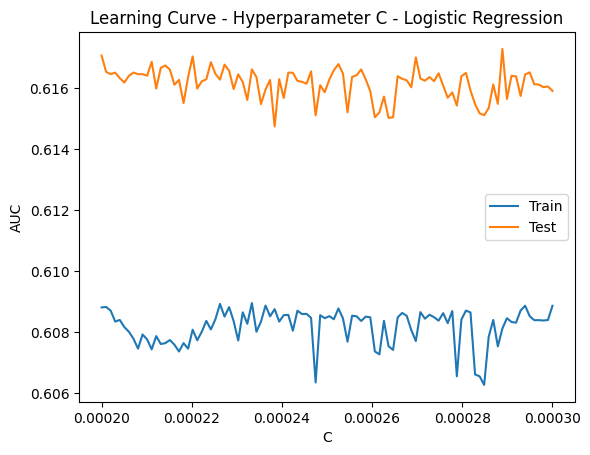

In [29]:
# learning curve
import numpy as np
param_values = [float(x) for x in np.linspace(0.0002, 0.0003, 100)]
draw_learning_curve(param_values)

In [10]:
y_train_over.value_counts()

TARGET
0    6980
1    6980
Name: count, dtype: int64

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.97
Recall (Train Set)      : 1.00
Recall (Test Set)       : 0.92
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.95
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.99
Recall (Crossval Train) : 1.0
Recall (Crossval Test)  : 0.9


In [26]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state = 42)
xg.fit(X_train, y_train)
eval_classification(xg)

Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.98
Recall (Train Set)      : 1.00
Recall (Test Set)       : 0.91
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.94
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
Recall (Crossval Train) : 1.0
Recall (Crossval Test)  : 0.89


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_app_train = pd.read_csv('application_train_inner_merged.csv')

df_app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100048       0                   0            0             0   
1      100135       0                   0            1             0   
2      100139       0                   0            0             0   
3      100180       0                   0            0             0   
4      100211       0                   0            1             0   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
0                1         12.218495                6                 6   
1                1         11.813030                6                 1   
2                0         11.967181                1                 6   
3                1         12.660328                6                 1   
4                0         12.323856                6                 1   

   NAME_EDUCATION_TYPE  ...  NAME_CONTRACT_STATUS_Signed  MONTHS_BALANCE  \
0                    4  ...                          0.0        1.266472   
1                    4  ...                          0.0        1.266472   
2                    4  ...                          0.0        1.266472   
3                    1  ...                          0.0        0.691023   
4                    4  ...                          0.0        1.266472   

   MONTHS_BALANCE.1  CNT_INSTALMENT_LOG  CNT_INSTALMENT_LOG.1  \
0          0.767749            0.043016              0.688250   
1         -0.191334            0.215436              6.032220   
2         -1.917683           -0.965957            -33.808493   
3          0.038846           -0.214046             -4.280917   
4          0.691023            0.414555              6.632886   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0         0.768120            0.776268        7.821250   
1         0.659363            0.637333        9.684913   
2        -0.069429           -0.064093        8.788192   
3         0.305974            0.303667        9.560450   
4         1.017882            1.026054        8.375453   

   DAYS_ENTRY_PAYMENT_RATIO  AMT_PAYMENT_DIFFERENCES  
0                 -0.000708                 0.188409  
1                  0.061707                 0.188409  
2                  0.016936                 0.066424  
3                  0.013983                -1.224114  
4                  0.015802                -0.126746  

[5 rows x 109 columns]

In [8]:
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Columns: 109 entries, SK_ID_CURR to AMT_PAYMENT_DIFFERENCES
dtypes: float64(57), int64(52)
memory usage: 9.2 MB


In [16]:
X = df_app_train.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_app_train['TARGET']

y.value_counts()

TARGET
0    9956
1    1087
Name: count, dtype: int64

In [19]:
from imblearn.over_sampling import SMOTE

resampling = SMOTE(sampling_strategy = 'minority', random_state = 42) 
X, y  = resampling.fit_resample(X, y)

y.value_counts()

TARGET
0    9956
1    9956
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred             = model.predict(X_test)
    y_pred_train       = model.predict(X_train)
    y_pred_proba       = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (Train Set)    : %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set)     : %.2f' % accuracy_score(y_test, y_pred))

    print('Precision (Train Set)   : %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test Set)    : %.2f' % precision_score(y_test, y_pred))

    print('Recall    (Train Set)   : %.2f' % recall_score(y_train, y_pred_train))
    print('Recall    (Test Set)    : %.2f' % recall_score(y_test, y_pred))

    print('F1-Score (Train Set)    : %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test Set)     : %.2f' % f1_score(y_test, y_pred))

    print('ROC-AUC (Train-Proba)   : %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC (Test-Proba)    : %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

    score = cross_validate(model, X, y, cv=5, scoring='recall', return_train_score=True)
    print('Recall (Crossval Train) : ' + str(score['train_score'].mean().round(2)))
    print('Recall (Crossval Test)  : ' + str(score['test_score'].mean().round(2)))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10,8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Train Set)    : 1.00
Accuracy (Test Set)     : 0.95
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.97
Recall    (Train Set)   : 1.00
Recall    (Test Set)    : 0.92
F1-Score (Train Set)    : 1.00
F1-Score (Test Set)     : 0.95
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.99
Recall (Crossval Train) : 1.0
Recall (Crossval Test)  : 0.9


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)

# Hitung confusion matrix
confusion_matrix(y_test, y_pred)

array([[1983,   47],
       [ 159, 1794]], dtype=int64)

In [42]:
# tuning hyperparameter RF
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, hyperparameters, scoring='roc_auc', random_state=1, cv=5)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Train Set)    : 0.98
Accuracy (Test Set)     : 0.94
Precision (Train Set)   : 1.00
Precision (Test Set)    : 0.96
Recall    (Train Set)   : 0.97
Recall    (Test Set)    : 0.91
F1-Score (Train Set)    : 0.98
F1-Score (Test Set)     : 0.93
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.98
Recall (Crossval Train) : 0.96
Recall (Crossval Test)  : 0.89


In [49]:
show_best_hyperparameter(rs)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 98, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 53, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [74]:
best_model = rs.best_estimator_
best_model

RandomForestClassifier(criterion='entropy', max_depth=98, min_samples_leaf=6,
                       min_samples_split=12, n_estimators=53, random_state=42)

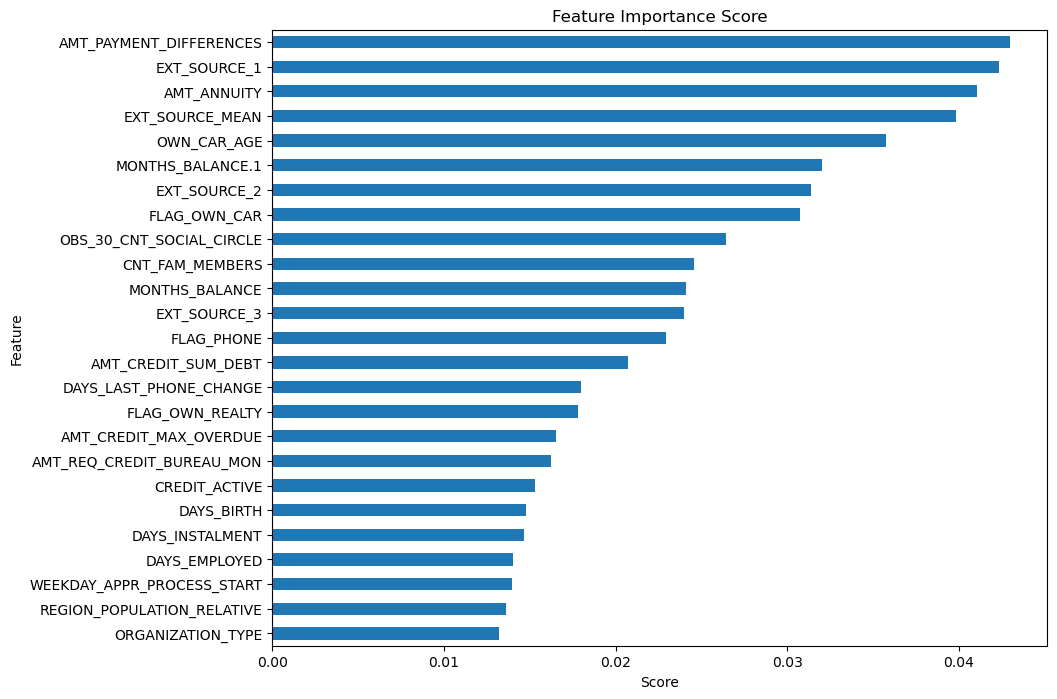

In [111]:
show_feature_importance(rs.best_estimator_)

In [ ]:
# Learning Curve

#param_values = [int(x) for x in np.linspace(1, 200, 50)] # n_estimatores
#param_values = [int(x) for x in np.linspace(2, 200, 50)] # max_depth
#param_values = [int(x) for x in np.linspace(2, 20, 15)] # min_samples_split
param_values = [int(x) for x in np.linspace(2, 20, 15)] # min_samples_leaf

train_scores= []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(n_estimators=139,  min_samples_leaf=c)
    #max_depth=6, min_samples_split=14,
    model.fit(X_train, y_train)

    # eval on train
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # eval on test
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value:' + str(c) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
show_feature_importance(rs.best_estimator_)

In [115]:
# Tentukan nilai optimal yang sudah ditemukan
optimal_n_estimators = 53
optimal_max_depth = 98
optimal_min_samples_split = 12
optimal_min_samples_leaf = 6

# Buat model dengan hyperparameter yang sudah optimal
model = RandomForestClassifier(n_estimators=optimal_n_estimators, 
                               max_depth=optimal_max_depth, 
                               min_samples_split=optimal_min_samples_split, 
                               min_samples_leaf=optimal_min_samples_leaf)

# Fit model pada data training
model.fit(X_train, y_train)

# Evaluasi model pada data training
y_pred_train_proba = model.predict_proba(X_train)
train_auc = roc_auc_score(y_train, y_pred_train_proba[:, 1])

# Evaluasi model pada data test
y_pred_proba = model.predict_proba(X_test)
test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print('Train AUC:', train_auc)
print('Test AUC:', test_auc)


Train AUC: 0.9987597383759289
Test AUC: 0.9777227910073928


In [ ]:
rf.get_params()